<a href="https://colab.research.google.com/github/donaldssh/3DAR_project_descriptors/blob/autoencoder/Surf_Autoencoder_3Ddesc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is meant to be used only for **experimenting and training the model**.
The actual compression on the decriptor will be carried out by a standard python script, that uses a pretrained model.


Or import dataset from drive

In [2]:
#warning: this only work for Daniele drive for now

! unzip /content/drive/MyDrive/UNI_ICT/3DAR/descriptors_dataset.zip

Archive:  /content/drive/MyDrive/UNI_ICT/3DAR/descriptors_dataset.zip
   creating: descriptors_dataset/
  inflating: descriptors_dataset/test_set.bin  
  inflating: descriptors_dataset/train_set.bin  


Import libraries

In [3]:
!pip install --quiet optuna


     |████████████████████████████████| 266kB 20.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.6MB/s 
     |████████████████████████████████| 163kB 53.8MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 133kB 60.1MB/s 
     |████████████████████████████████| 112kB 21.0MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 


In [4]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import notebook, tqdm # this module is useful to plot progress bars
from sklearn.decomposition import PCA
import json
import numba

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torchvision import transforms
import torchvision
import optuna

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda


load binary file with descriptor as dataframe

In [5]:
train_path = '/content/descriptors_dataset/train_set.bin'
test_path = '/content/descriptors_dataset/test_set.bin'

train_raw = np.fromfile(train_path, dtype='float32')
test_raw = np.fromfile(test_path, dtype='float32')
print(np.shape(train_raw), np.shape(test_raw))

train_set = np.reshape(train_raw, (np.shape(train_raw)[0]//128,128))
test_set = np.reshape(test_raw, (np.shape(test_raw)[0]//128,128))
print(np.shape(train_set), np.shape(test_set))

# convert in dataframe
train_set = pd.DataFrame(train_set)
test_set = pd.DataFrame(test_set)
train_set

(10734848,) (40188800,)
(83866, 128) (313975, 128)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.003977,0.004094,0.001158,0.001211,0.002178,0.003975,0.000147,0.000201,0.001390,0.003913,-0.000623,0.002208,0.005872,0.008583,-0.002544,0.015829,0.000715,0.002617,-0.000757,0.000757,0.011567,0.011567,-0.002198,0.011475,0.000259,0.001516,-0.000049,0.000125,0.001687,0.001793,0.000211,0.001526,0.005941,0.026585,0.003818,0.005092,0.011648,0.012168,0.009961,0.013242,...,-0.013263,0.021591,-0.025073,0.028366,0.001998,0.004193,-0.001465,0.010882,0.000015,0.000258,-0.000728,0.004353,-0.003504,0.005917,-0.005797,0.007094,0.007245,0.008251,0.002095,0.026427,-0.014260,0.066804,-0.009374,0.013389,0.021637,0.024003,0.012856,0.017909,-0.005929,0.052598,-0.001135,0.002862,-0.000623,0.002579,-0.003556,0.008000,-0.000592,0.001290,-0.003214,0.004261
1,-0.000293,0.000293,-0.003658,0.004107,-0.000295,0.000295,-0.000710,0.000769,0.015767,0.016046,0.000607,0.000941,0.023647,0.026446,0.001809,0.002040,-0.001588,0.014385,0.000764,0.000764,0.009594,0.014873,0.036861,0.036861,-0.000197,0.000770,-0.000178,0.001410,-0.001487,0.002953,-0.000460,0.001125,-0.006272,0.009139,-0.016423,0.016775,0.000807,0.001474,-0.001565,0.004249,...,0.000827,0.001472,-0.003930,0.010274,-0.001455,0.004035,-0.016245,0.017724,-0.002277,0.002452,-0.001581,0.001704,-0.000149,0.000339,0.000090,0.000613,0.013206,0.013767,0.026404,0.026404,-0.019698,0.027909,0.001750,0.001750,-0.002019,0.013576,-0.011187,0.014943,0.003926,0.012494,0.004074,0.019268,-0.000081,0.000118,0.000700,0.001190,-0.004601,0.004902,-0.000284,0.001319
2,0.010813,0.010813,0.000291,0.000291,0.001760,0.005130,0.000000,0.000000,0.000241,0.007325,0.026263,0.030316,-0.013533,0.018234,0.002195,0.005281,-0.007102,0.018575,0.005042,0.006173,0.012045,0.015462,0.017483,0.018600,-0.014475,0.014626,0.000003,0.000409,-0.000145,0.000187,0.009671,0.009992,0.015915,0.040549,0.007860,0.017681,0.039719,0.042033,0.003356,0.017884,...,-0.004884,0.006757,-0.005454,0.007741,0.000582,0.005033,0.001032,0.011677,-0.001195,0.001386,-0.000056,0.001444,-0.000080,0.001088,-0.001439,0.005315,0.002129,0.007017,-0.008177,0.023996,-0.029093,0.031962,-0.021619,0.038434,0.003283,0.006301,0.033493,0.038111,-0.083176,0.085348,-0.011287,0.011530,0.000288,0.000288,0.002962,0.003077,-0.005183,0.005271,-0.000026,0.000026
3,0.005997,0.006357,0.000054,0.000306,0.001673,0.002640,0.000307,0.000543,0.009311,0.011456,-0.001183,0.001958,0.014703,0.022361,-0.004418,0.018720,0.001868,0.003555,-0.001477,0.001626,0.012298,0.012566,-0.004839,0.015172,0.000370,0.000543,-0.000222,0.000250,0.002694,0.002854,-0.000972,0.001394,0.049242,0.053013,0.009259,0.019462,0.022581,0.026116,-0.010796,0.013292,...,0.022688,0.024289,0.005790,0.005790,-0.000733,0.017632,0.005675,0.005675,-0.000323,0.000536,-0.003245,0.003951,-0.001064,0.001335,-0.003917,0.004029,0.006944,0.006959,0.010044,0.012008,0.012423,0.036095,-0.003238,0.003282,0.018653,0.034861,-0.001061,0.011504,0.010193,0.040627,-0.013101,0.014622,0.004226,0.004396,0.004223,0.004724,-0.002316,0.006061,-0.000327,0.001271
4,-0.003744,0.004577,0.003334,0.007550,0.000702,0.001265,0.001506,0.002862,-0.025747,0.031493,0.000575,0.003369,-0.000589,0.000589,0.003023,0.003702,0.003578,0.005398,0.000923,0.003605,0.002636,0.005576,-0.003938,0.004637,-0.001479,0.001509,0.000000,0.000000,0.000040,0.000040,0.005008,0.005008,0.031937,0.035476,0.022561,0.033477,0.004729,0.036002,-0.006248,0.007834,...,-0.047558,0.049634,-0.000394,0.006985,-0.001230,0.003997,0.011124,0.011651,0.006029,0.006036,0.001956,0.001956,0.000320,0.002108,0.000001,0.000001,0.000343,0.031619,0.024123,0.055669,-0.012209,0.032383,0.003623,0.007440,-0.017665,0.030742,0.009345,0.024186,-0.004515,0.016965,0.002319,0.015140,-0.004457,0.005334,-0.000316,0.000371,0.000147,0.000629,0.000537,0.001126
...,...,...,...,

# Analysis on the descriptors structure

Knowing the SURF algorithm, can we find regularities and exploit them for the design of a more efficient autoencoder?

opencv implementation about the writing of the 128 bin descriptor.
From https://github.com/opencv/opencv_contrib/blob/master/modules/xfeatures2d/src/surf.cpp at line 795

```
// 128-bin descriptor
                for( i = 0; i < 4; i++ )
                    for( j = 0; j < 4; j++ )
                    {
                        for(int y = i*5; y < i*5+5; y++ )
                        {
                            for(int x = j*5; x < j*5+5; x++ )
                            {
                                float tx = DX[y][x], ty = DY[y][x];
                                if( ty >= 0 )
                                {
                                    vec[0] += tx;
                                    vec[1] += (float)fabs(tx);
                                } else {
                                    vec[2] += tx;
                                    vec[3] += (float)fabs(tx);
                                }
                                if ( tx >= 0 )
                                {
                                    vec[4] += ty;
                                    vec[5] += (float)fabs(ty);
                                } else {
                                    vec[6] += ty;
                                    vec[7] += (float)fabs(ty);
                                }
                            }
                        }
                        for( kk = 0; kk < 8; kk++ )
                            square_mag += vec[kk]*vec[kk];
                        vec += 8;
                    }
```



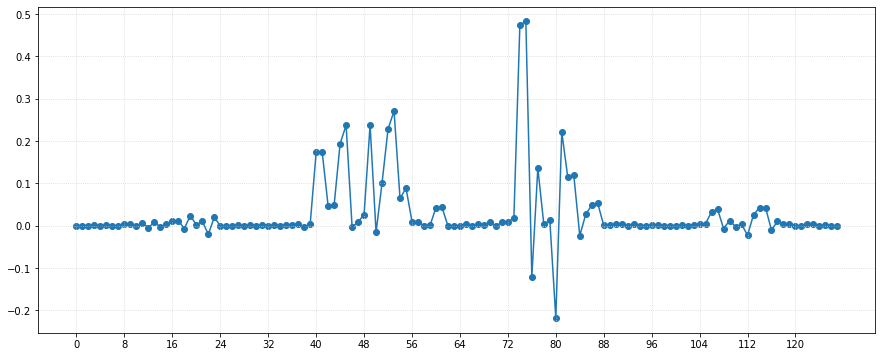

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xticks(np.arange(0,128,8))
ax.scatter(range(128),train_set.iloc[10,:])
ax.plot(range(128), train_set.iloc[10,:])
ax.grid(color='lightgray', linestyle=':')

Visualize the superposition of many random chosen descriptors

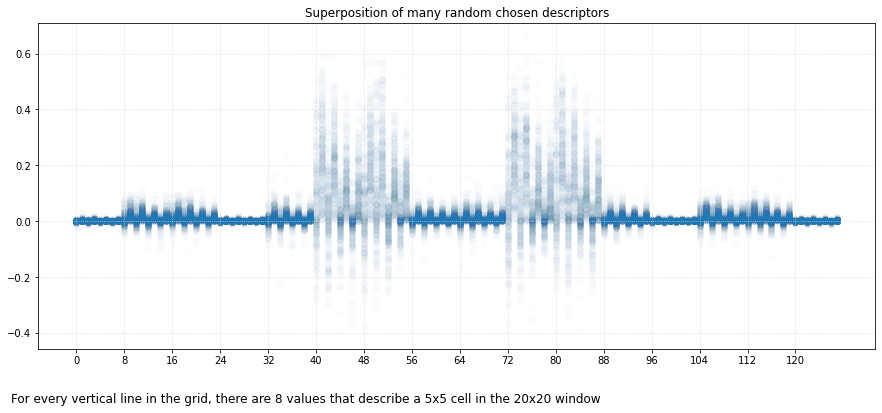

In [ ]:

fig, ax = plt.subplots(figsize=(15,6))

for i in range(300):
    n = int(np.ceil(np.random.uniform()*len(train_set)))
    # ax.plot(range(128), train_set.iloc[n,:], alpha=0.01, color='#1f77b4')
    ax.scatter(range(128), train_set.iloc[n,:], alpha=0.01, color='#1f77b4')
    ax.set_xticks(np.arange(0,128,8))
    ax.grid(color='lightgray', linestyle=':')
ax.set_title("Superposition of many random chosen descriptors")
plt.figtext(0.1,0,'For every vertical line in the grid, there are 8 values that describe a 5x5 cell in the 20x20 window', fontsize = 12)
plt.show()

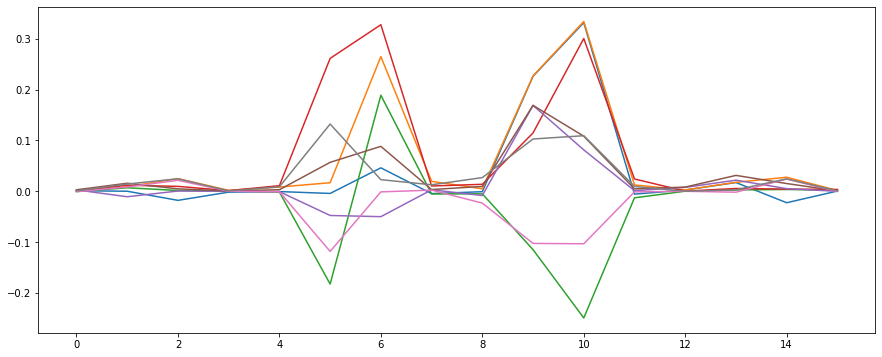

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(1):
    n = int(np.ceil(np.random.uniform()*len(train_set)))
    # ax.plot(range(128), train_set.iloc[n,:], alpha=0.01, color='#1f77b4')
    sample = train_set.iloc[n,:].to_numpy().reshape(16,8)
    ax.plot(sample)

    # ax.scatter(range(128), train_set.iloc[n,:], alpha=0.01, color='#1f77b4')
    # ax.set_xticks(np.arange(0,128,8))
    # ax.grid(color='lightgray', linestyle=':')
# ax.set_title("Superposition of many random chosen descriptors")
# plt.figtext(0.1,0,'For every vertical line in the grid, there are 8 values that describe a 5x5 cell in the 20x20 window', fontsize = 12)
# plt.show()

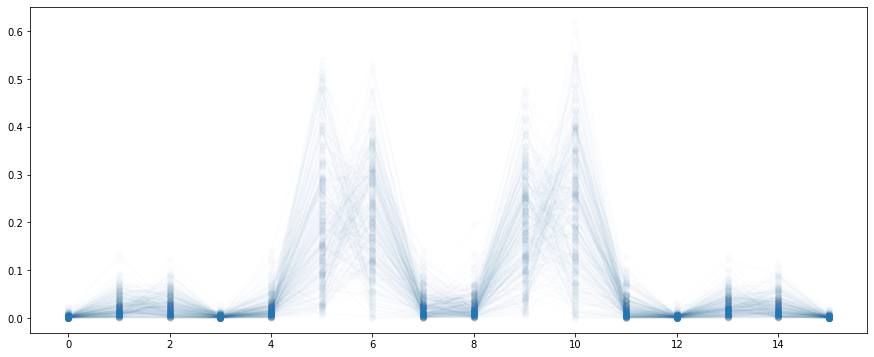

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(300):
    n = int(np.ceil(np.random.uniform()*len(train_set)))
    ax.plot(range(128//8), train_set.iloc[n,1:129:8], alpha=0.01, color='#1f77b4')
    ax.scatter(range(128//8), train_set.iloc[n,1:129:8], alpha=0.01, color='#1f77b4')


Is it useful to consider every descriptor as a 8 channels 4x4 image? we could implement a convolutional autoencoder

Visualize the superposition of many random chosen fft of the descriptor (maybe not useful)


# Dataset preparation

normalize transformation class

In [7]:
class NpToTensor():
    def __call__(self, array):
        return torch.from_numpy(array)


reshaping 3D

In [8]:
class Surf3DReshape():
    def __call__(self, desc):
        channels = []
        for i in range(8):
            channels.append(np.reshape(desc[i:128:8], (4,4)))
        channels = np.dstack(channels)
        channels = np.transpose(channels, (2,0,1))
        return channels


In [9]:
print(np.max(train_raw), np.min(train_raw))
print(np.max(test_raw), np.min(test_raw))

0.80932486 -0.53642845
0.88342446 -0.5417158


Define descriptor dataset class

In [10]:
class SurfDataset(Dataset):

    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #return a nparray from the dataframe
        sample = self.data.iloc[idx,:].to_numpy()
        if self.transform:
            sample = self.transform(sample)
        return sample

composed_transform = transforms.Compose([Surf3DReshape(), NpToTensor()])

train_dataset = SurfDataset(train_set, transform=composed_transform)
test_dataset = SurfDataset(test_set, transform=composed_transform)

print(np.shape(train_dataset.__getitem__(100)))

train_dataset, val_dataset = random_split(train_dataset, [int(0.8*len(train_dataset)), len(train_dataset)-int(0.8*len(train_dataset))])


torch.Size([8, 4, 4])


# Convolutional Autoencoder class

In [11]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(8, conv1_ch, 3, stride=1, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(conv1_ch, conv2_ch, 3, stride=1, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(conv2_ch, conv3_ch, 3, stride=1, padding=0),  #make it 3x3
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(2 * 2 * conv3_ch, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        # print(np.shape(x))
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, 2 * 2 * conv3_ch),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3_ch, 2, 2))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3_ch, conv2_ch, 3, stride=1, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2_ch, conv1_ch, 3, stride=1, padding=1, output_padding=0),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1_ch, 8, 3, stride=1, padding=1, output_padding=0)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # print(np.shape(x))
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # # Apply a sigmoid to force the output to be between 0 and 1 
        # x = torch.sigmoid(x)
        return x


encoder = Encoder(2, 16, 32,64, 50)
decoder = Decoder(2, 16, 32,64, 50)

sample = train_dataset.__getitem__(10).unsqueeze(0)
print(np.shape(sample))

output = decoder(encoder(sample))
print(np.shape(output))

torch.Size([1, 8, 4, 4])
torch.Size([1, 8, 4, 4])


# Training preparation

In [12]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for surf_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        surf_batch = surf_batch.to(device)
        # Encode data
        encoded_data = encoder(surf_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, surf_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
    
    return loss.data

In [13]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for surf_batch in dataloader:
            # Move tensor to the proper device
            surf_batch = surf_batch.to(device)
            # Encode data
            encoded_data = encoder(surf_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(surf_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

# Parameters search with Optuna

In [14]:
def objective(trial):

    #suggest parameters
    encoded_space_dim = trial.suggest_int('encoded_space_dim', 2,10)
    batch_size = trial.suggest_int('batch_size', 200, 1000)
    optim = trial.suggest_categorical('optim', ['Adam', 'SGD'])
    conv1_ch = trial.suggest_categorical('conv1_ch', [32,64,128])
    conv2_ch = trial.suggest_categorical('conv2_ch', [32,64,128])
    conv3_ch = trial.suggest_categorical('conv3_ch', [32,64,128])
    fc_ch = trial.suggest_categorical('fc_ch', [32,64,128])
    


    #make dataloaders
    # train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    train_dataloader = DataLoader(train_dataset_reduced, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset_reduced, batch_size=batch_size, shuffle=False)


    # initialize models
    encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
    decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    if optim == 'Adam':
        optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
    elif optim == 'SGD':
        optim = torch.optim.SGD(params_to_optimize, lr=lr, weight_decay=1e-5)
    
    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)


    # Training Loop
    display = False
    num_epochs = 50 #just smoke test

    train_loss_record = []
    val_loss_record = []
    for epoch in notebook.tqdm(range(num_epochs)):
        if display:
            print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

        train_loss_batch_record = []
        val_loss_batch_record = []
        ### Training (use the training function)
        train_loss_batch = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_batch_record.append(train_loss_batch)
        ### Validation  (use the testing function)
        val_loss_batch = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        val_loss_batch_record.append(val_loss_batch)
        if display:
        # Print Validationloss
            print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                    sum(train_loss_batch_record)/len(train_loss_batch_record)))
            print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

        #store losses for this epoch
        train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
        val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))



        # call back optuna for pruning
        trial.report(sum(val_loss_batch_record)/len(val_loss_batch_record), epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        #end of training loop
    
    final_val_loss = val_loss_record[-1]
    

    
    return final_val_loss

In [18]:
#use reduced datasets for speed 
rtrain_size = 10000
rval_size = 1000
train_dataset_reduced, _ = random_split(train_dataset, [rtrain_size, len(train_dataset)-rtrain_size])
val_dataset_reduced, _ = random_split(val_dataset, [rval_size, len(val_dataset)-rval_size])


In [ ]:
study = optuna.create_study(direction='minimize', 
                            pruner=optuna.pruners.MedianPruner( 
                                n_startup_trials=5, n_warmup_steps=5, interval_steps=1))
study.optimize(objective, n_trials=50)

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2020-12-21 22:19:29,571] A new study created in memory with name: no-name-10289676-cec9-4866-9db0-09933ec93229


[I 2020-12-21 22:21:13,107] Trial 0 finished with value: 0.004319332540035248 and parameters: {'encoded_space_dim': 9, 'batch_size': 242, 'optim': 'SGD', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.011329838903280981}. Best is trial 0 with value: 0.004319332540035248.


[I 2020-12-21 22:22:50,160] Trial 1 finished with value: 0.005973493680357933 and parameters: {'encoded_space_dim': 6, 'batch_size': 876, 'optim': 'SGD', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.018553178008375113}. Best is trial 0 with value: 0.004319332540035248.


[I 2020-12-21 22:24:34,005] Trial 2 finished with value: 0.003604370402172208 and parameters: {'encoded_space_dim': 8, 'batch_size': 333, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.0011165684994305482}. Best is trial 2 with value: 0.003604370402172208.


[I 2020-12-21 22:26:14,913] Trial 3 finished with value: 0.005444773472845554 and parameters: {'encoded_space_dim': 4, 'batch_size': 322, 'optim': 'SGD', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.005373167791497699}. Best is trial 2 with value: 0.003604370402172208.


[I 2020-12-21 22:27:54,064] Trial 4 finished with value: 0.006236964371055365 and parameters: {'encoded_space_dim': 2, 'batch_size': 559, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 32, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.05911337994624254}. Best is trial 2 with value: 0.003604370402172208.


[I 2020-12-21 22:29:32,317] Trial 5 finished with value: 0.0036081946454942226 and parameters: {'encoded_space_dim': 8, 'batch_size': 674, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.005126616069558522}. Best is trial 2 with value: 0.003604370402172208.


[I 2020-12-21 22:31:10,383] Trial 6 finished with value: 0.003603179706260562 and parameters: {'encoded_space_dim': 9, 'batch_size': 653, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0002713673178845367}. Best is trial 6 with value: 0.003603179706260562.


[I 2020-12-21 22:31:22,238] Trial 7 pruned. 


[I 2020-12-21 22:31:34,824] Trial 8 pruned. 


[I 2020-12-21 22:33:13,585] Trial 9 finished with value: 0.0024497942067682743 and parameters: {'encoded_space_dim': 5, 'batch_size': 768, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.013214233659129295}. Best is trial 9 with value: 0.0024497942067682743.


[I 2020-12-21 22:34:51,277] Trial 10 finished with value: 0.0036025524605065584 and parameters: {'encoded_space_dim': 5, 'batch_size': 810, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 32, 'lr': 0.0012498475669754957}. Best is trial 9 with value: 0.0024497942067682743.


[I 2020-12-21 22:36:28,564] Trial 11 finished with value: 0.003602554090321064 and parameters: {'encoded_space_dim': 5, 'batch_size': 809, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 32, 'lr': 0.00141797055693825}. Best is trial 9 with value: 0.0024497942067682743.


[I 2020-12-21 22:38:06,873] Trial 12 finished with value: 0.003604162484407425 and parameters: {'encoded_space_dim': 3, 'batch_size': 764, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 32, 'lr': 0.0016861145814764575}. Best is trial 9 with value: 0.0024497942067682743.


[I 2020-12-21 22:38:19,042] Trial 13 pruned. 


[I 2020-12-21 22:38:30,698] Trial 14 pruned. 


[I 2020-12-21 22:40:09,242] Trial 15 finished with value: 0.0023182290606200695 and parameters: {'encoded_space_dim': 4, 'batch_size': 748, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002509708827075782}. Best is trial 15 with value: 0.0023182290606200695.


[I 2020-12-21 22:41:46,961] Trial 16 finished with value: 0.003603058634325862 and parameters: {'encoded_space_dim': 2, 'batch_size': 726, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.003984875623784638}. Best is trial 15 with value: 0.0023182290606200695.


[I 2020-12-21 22:41:58,835] Trial 17 pruned. 


[I 2020-12-21 22:42:11,076] Trial 18 pruned. 


[I 2020-12-21 22:43:48,369] Trial 19 finished with value: 0.0017533140489831567 and parameters: {'encoded_space_dim': 7, 'batch_size': 617, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00011198289113654311}. Best is trial 19 with value: 0.0017533140489831567.


[I 2020-12-21 22:45:28,628] Trial 20 finished with value: 0.0020350294653326273 and parameters: {'encoded_space_dim': 7, 'batch_size': 438, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00011997893848506074}. Best is trial 19 with value: 0.0017533140489831567.


[I 2020-12-21 22:47:09,023] Trial 21 finished with value: 0.0020224428735673428 and parameters: {'encoded_space_dim': 7, 'batch_size': 423, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00011249007226511005}. Best is trial 19 with value: 0.0017533140489831567.


[I 2020-12-21 22:47:23,413] Trial 22 pruned. 


[I 2020-12-21 22:49:03,162] Trial 23 finished with value: 0.0020635214168578386 and parameters: {'encoded_space_dim': 7, 'batch_size': 443, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00013427139343138953}. Best is trial 19 with value: 0.0017533140489831567.


[I 2020-12-21 22:49:15,107] Trial 24 pruned. 


[I 2020-12-21 22:50:57,629] Trial 25 finished with value: 0.0017063514096662402 and parameters: {'encoded_space_dim': 10, 'batch_size': 377, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00010127810890908383}. Best is trial 25 with value: 0.0017063514096662402.


[I 2020-12-21 22:51:10,029] Trial 26 pruned. 


[I 2020-12-21 22:51:21,662] Trial 27 pruned. 


[I 2020-12-21 22:51:34,179] Trial 28 pruned. 


[I 2020-12-21 22:51:46,294] Trial 29 pruned. 


[I 2020-12-21 22:53:34,626] Trial 30 finished with value: 0.0016668579773977399 and parameters: {'encoded_space_dim': 9, 'batch_size': 205, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00011013186028077716}. Best is trial 30 with value: 0.0016668579773977399.


[I 2020-12-21 22:55:21,776] Trial 31 finished with value: 0.001994411926716566 and parameters: {'encoded_space_dim': 9, 'batch_size': 206, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00010706667061241827}. Best is trial 30 with value: 0.0016668579773977399.


[I 2020-12-21 22:56:34,124] Trial 32 pruned. 


[I 2020-12-21 22:57:02,934] Trial 33 pruned. 


[I 2020-12-21 22:58:48,170] Trial 34 finished with value: 0.0019641423132270575 and parameters: {'encoded_space_dim': 9, 'batch_size': 240, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00018684760585242248}. Best is trial 30 with value: 0.0016668579773977399.


[I 2020-12-21 22:59:00,240] Trial 35 pruned. 


[I 2020-12-21 23:00:08,511] Trial 36 pruned. 


[I 2020-12-21 23:00:21,010] Trial 37 pruned. 


[I 2020-12-21 23:01:58,634] Trial 38 finished with value: 0.0021106728818267584 and parameters: {'encoded_space_dim': 9, 'batch_size': 509, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.00015785476704661418}. Best is trial 30 with value: 0.0016668579773977399.


[I 2020-12-21 23:02:23,689] Trial 39 pruned. 


[I 2020-12-21 23:02:35,321] Trial 40 pruned. 


[I 2020-12-21 23:04:21,483] Trial 41 finished with value: 0.0015535484999418259 and parameters: {'encoded_space_dim': 9, 'batch_size': 216, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0001018935810754378}. Best is trial 41 with value: 0.0015535484999418259.


[I 2020-12-21 23:04:33,716] Trial 42 pruned. 


[I 2020-12-21 23:06:18,923] Trial 43 finished with value: 0.0019815226551145315 and parameters: {'encoded_space_dim': 8, 'batch_size': 231, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0002725363232972353}. Best is trial 41 with value: 0.0015535484999418259.


[I 2020-12-21 23:08:02,038] Trial 44 finished with value: 0.0020043612457811832 and parameters: {'encoded_space_dim': 9, 'batch_size': 253, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0001017082731123451}. Best is trial 41 with value: 0.0015535484999418259.


[I 2020-12-21 23:08:14,137] Trial 45 pruned. 


[I 2020-12-21 23:08:25,802] Trial 46 pruned. 


[I 2020-12-21 23:08:39,081] Trial 47 pruned. 


[I 2020-12-21 23:08:50,584] Trial 48 pruned. 


[I 2020-12-21 23:09:49,025] Trial 49 pruned. 


val Loss: 0.0015535484999418259
Best hyperparameters: {'encoded_space_dim': 9, 'batch_size': 216, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0001018935810754378}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

# training on best parameters

In [16]:
best_params = {'encoded_space_dim': 9, 'batch_size': 216, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0001018935810754378}

In [19]:
#use reduced datasets for speed 
rtrain_size = len(train_dataset)
rval_size = len(val_dataset)
train_dataset_reduced, _ = random_split(train_dataset, [rtrain_size, len(train_dataset)-rtrain_size])
val_dataset_reduced, _ = random_split(val_dataset, [rval_size, len(val_dataset)-rval_size])


In [21]:
#best parameters
encoded_space_dim = best_params['encoded_space_dim']
batch_size = best_params['batch_size']
optim = best_params['optim']
conv1_ch = best_params['conv1_ch']
conv2_ch = best_params['conv2_ch']
conv3_ch = best_params['conv3_ch']
fc_ch = best_params['fc_ch']
lr = best_params['lr']


#make dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset_reduced, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset_reduced, batch_size=batch_size, shuffle=False)


# initialize models
encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
if optim == 'Adam':
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
elif optim == 'RMSprop':
    optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)


# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


# Training Loop
display = False
num_epochs = 50 

train_loss_record = []
val_loss_record = []
for epoch in notebook.tqdm(range(num_epochs)):
    if display:
        print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

    train_loss_batch_record = []
    val_loss_batch_record = []
    ### Training (use the training function)
    train_loss_batch = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    train_loss_batch_record.append(train_loss_batch)
    ### Validation  (use the testing function)
    val_loss_batch = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    val_loss_batch_record.append(val_loss_batch)
    if display:
    # Print Validationloss
        print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                sum(train_loss_batch_record)/len(train_loss_batch_record)))
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

    #store losses for this epoch
    train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
    val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))


In [22]:
# Save the state dict to a file
torch.save(encoder.state_dict(), 'best_encoder.torch')
torch.save(decoder.state_dict(), 'best_decoder.torch')

In [24]:
print(val_loss_record[-1])

tensor(0.0016)


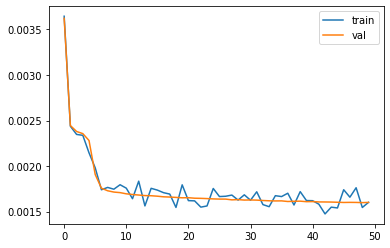

In [26]:
plt.plot(train_loss_record, label='train')
plt.plot(val_loss_record, label='val')
plt.legend()
plt.show()

# Comparison on reconstructed samples

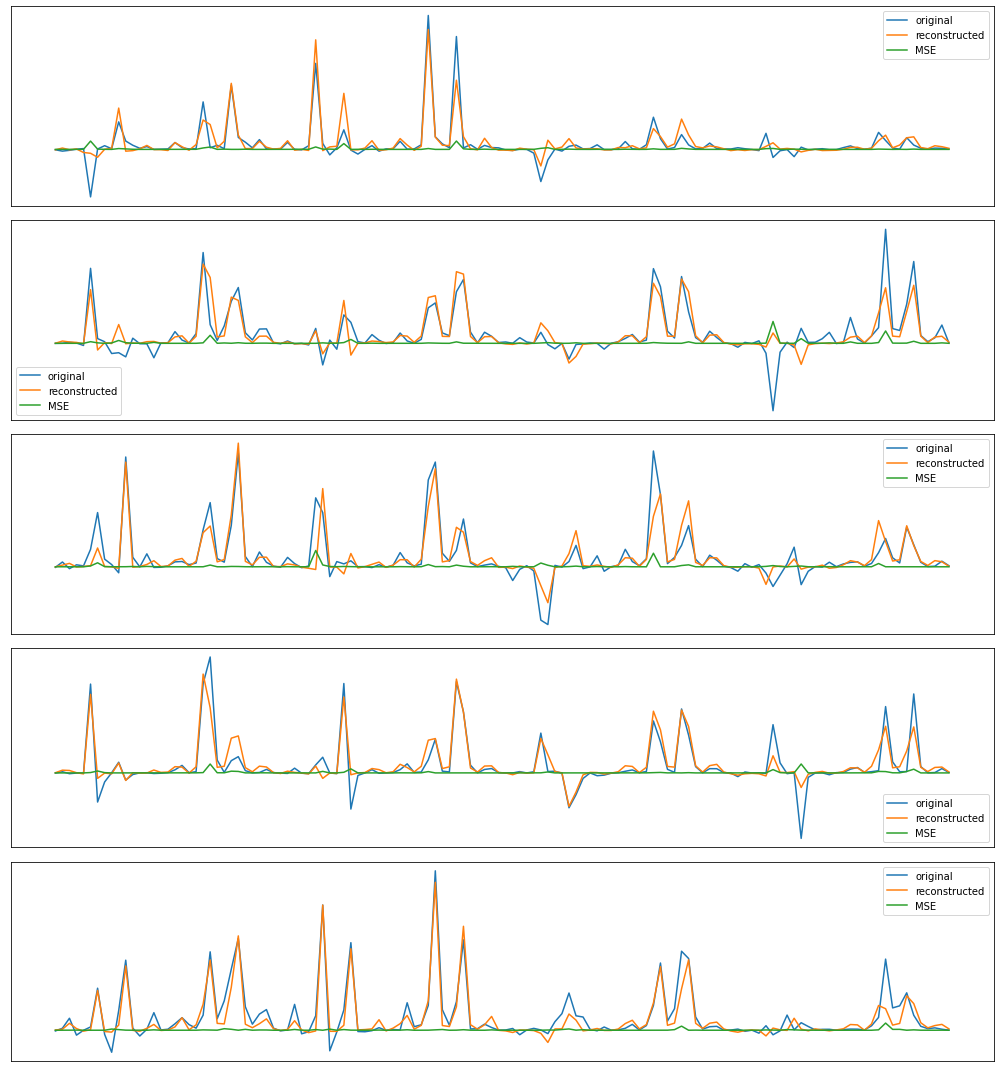

In [28]:
best_encoder = encoder
best_decoder = decoder

rows = 5
fig, ax = plt.subplots(rows, 1, figsize=(14,15))
for i in range(rows):
    img = random.choice(train_dataset_reduced)
    img = img.unsqueeze(0).to(device)
    best_encoder.eval()
    best_decoder.eval()
    with torch.no_grad():
        rec_img  = best_decoder(best_encoder(img))
    ax[i].plot(img.cpu().squeeze().numpy().reshape(128,), label='original')
    ax[i].plot(rec_img.cpu().squeeze().numpy().reshape(128,), label='reconstructed')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].plot((rec_img.cpu().squeeze().numpy().reshape(128,)-img.cpu().squeeze().numpy().reshape(128,))**2, label='MSE')
    ax[i].legend()

plt.tight_layout()